# scRNA-Seq Analysis Final Project 

### Data Loading and Libraries 

In [1]:
import scanpy as sc
import anndata as ad
import celltypist
from celltypist import models
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
data_dir = "/Users/jriya/Desktop/final_project/GSE197177_RAW"

# Iterate over each subdirectory
for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):  # Ensure it's a directory
        for file in os.listdir(subdir_path):
            # Identify the type of file and rename it
            if "barcodes.tsv.gz" in file:
                os.rename(
                    os.path.join(subdir_path, file),
                    os.path.join(subdir_path, "barcodes.tsv.gz"),
                )
            elif "features.tsv.gz" in file:
                os.rename(
                    os.path.join(subdir_path, file),
                    os.path.join(subdir_path, "features.tsv.gz"),
                )
            elif "matrix.mtx.gz" in file:
                os.rename(
                    os.path.join(subdir_path, file),
                    os.path.join(subdir_path, "matrix.mtx.gz"),
                )

print("Files renamed successfully!")


Files renamed successfully!


In [3]:
data_dir = "/Users/jriya/Desktop/final_project/GSE197177_RAW"

# Read each sample and store in a dictionary
adata_dict = {}
for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        print(f"Reading data from {subdir_path}...")
        # Read the 10x mtx data
        adata = sc.read_10x_mtx(subdir_path, var_names="gene_symbols")
        # Add the sample ID to the observation metadata
        adata.obs["sample_id"] = subdir
        # Save the AnnData object in the dictionary with the sample name as the key
        adata_dict[subdir] = adata

# Check the keys of the dictionary (sample names)
print("Samples loaded:", adata_dict.keys())

Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910789_Case3-YF...
Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910785_Case1-ZY...
Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910786_Case2-ZC...
Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910790_Case3-ZY...
Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910791_Case4-ZY...
Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910784_Case1-YF...
Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910788_Case2-ZY...
Reading data from /Users/jriya/Desktop/final_project/GSE197177_RAW/GSM5910787_Case2-YF...
Samples loaded: dict_keys(['GSM5910789_Case3-YF', 'GSM5910785_Case1-ZY', 'GSM5910786_Case2-ZC', 'GSM5910790_Case3-ZY', 'GSM5910791_Case4-ZY', 'GSM5910784_Case1-YF', 'GSM5910788_Case2-ZY', 'GSM5910787_Case2-YF'])


#### General Information about data

In [4]:
# number of genes and cells 
for sample_name, adata in adata_dict.items():
    num_cells, num_genes = adata.shape
    print(f"Sample: {sample_name}")
    print(f"  Number of cells: {num_cells}")
    print(f"  Number of genes: {num_genes}")


Sample: GSM5910789_Case3-YF
  Number of cells: 9379
  Number of genes: 33538
Sample: GSM5910785_Case1-ZY
  Number of cells: 13685
  Number of genes: 33538
Sample: GSM5910786_Case2-ZC
  Number of cells: 6606
  Number of genes: 33538
Sample: GSM5910790_Case3-ZY
  Number of cells: 8837
  Number of genes: 33538
Sample: GSM5910791_Case4-ZY
  Number of cells: 2024
  Number of genes: 33538
Sample: GSM5910784_Case1-YF
  Number of cells: 21560
  Number of genes: 33538
Sample: GSM5910788_Case2-ZY
  Number of cells: 9406
  Number of genes: 33538
Sample: GSM5910787_Case2-YF
  Number of cells: 11786
  Number of genes: 33538


### Preprocessing: Quality Control, Doublet detection and Visualization 

In [5]:
# Set thresholds for filtering
mito_threshold = 10
min_genes = 200
max_genes = 2500

filtered_dict = {}

for sample_name, adata in adata_dict.items():
    print(f"\nPreparing and filtering {sample_name}...")

    # 1. Identify mitochondrial genes
    if "mt" not in adata.var.columns:
        adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
    
    # 2. Compute QC metrics
    required_qc_cols = {"n_genes_by_counts", "pct_counts_mt", "total_counts"}
    if not required_qc_cols.issubset(set(adata.obs.columns)):
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

    # 3. Filter cells
    adata = adata[adata.obs["pct_counts_mt"] < mito_threshold, :]
    adata = adata[adata.obs["n_genes_by_counts"] > min_genes, :]
    adata = adata[adata.obs["n_genes_by_counts"] < max_genes, :]

    # 4. Save the filtered sample
    filtered_dict[sample_name] = adata
    print(f"After filtering {sample_name}: {adata.shape[0]} cells, {adata.shape[1]} genes")



Preparing and filtering GSM5910789_Case3-YF...
After filtering GSM5910789_Case3-YF: 5084 cells, 33538 genes

Preparing and filtering GSM5910785_Case1-ZY...
After filtering GSM5910785_Case1-ZY: 3818 cells, 33538 genes

Preparing and filtering GSM5910786_Case2-ZC...
After filtering GSM5910786_Case2-ZC: 5685 cells, 33538 genes

Preparing and filtering GSM5910790_Case3-ZY...
After filtering GSM5910790_Case3-ZY: 3556 cells, 33538 genes

Preparing and filtering GSM5910791_Case4-ZY...
After filtering GSM5910791_Case4-ZY: 1095 cells, 33538 genes

Preparing and filtering GSM5910784_Case1-YF...
After filtering GSM5910784_Case1-YF: 1875 cells, 33538 genes

Preparing and filtering GSM5910788_Case2-ZY...
After filtering GSM5910788_Case2-ZY: 7543 cells, 33538 genes

Preparing and filtering GSM5910787_Case2-YF...
After filtering GSM5910787_Case2-YF: 7200 cells, 33538 genes


Creating QC violin plot for GSM5910789_Case3-YF...


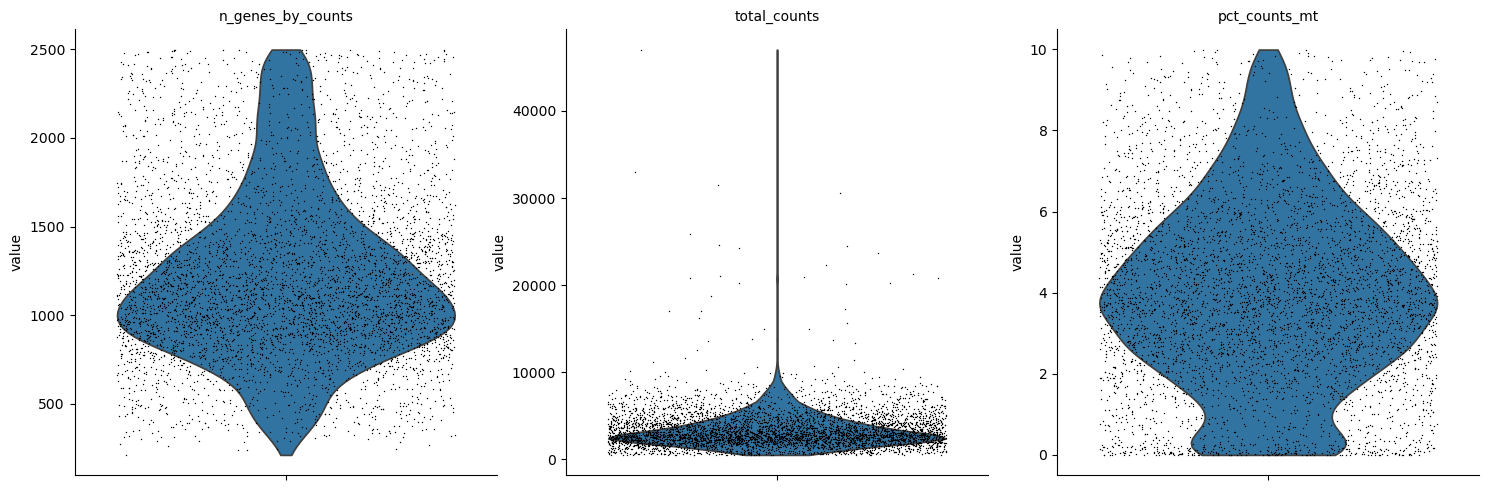

Creating QC violin plot for GSM5910785_Case1-ZY...


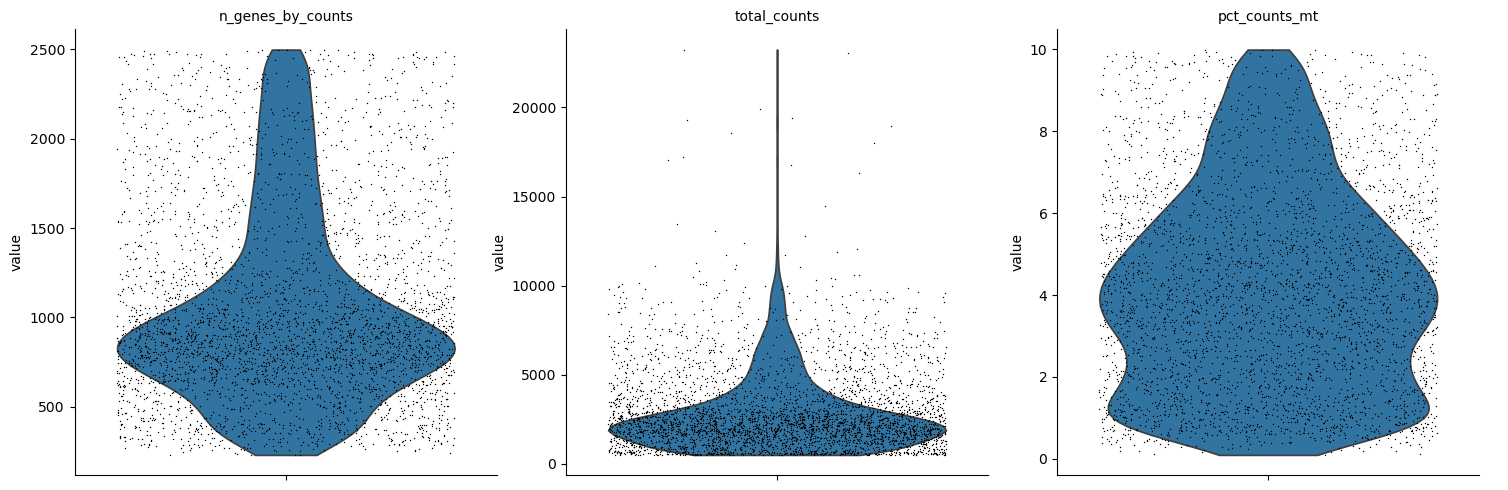

Creating QC violin plot for GSM5910786_Case2-ZC...


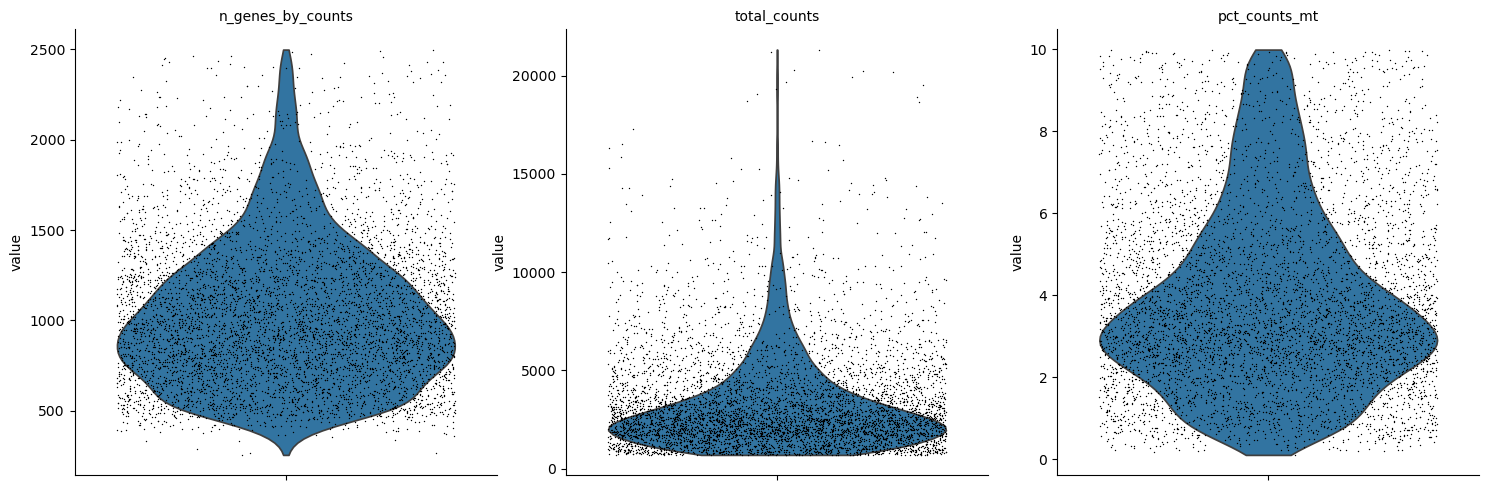

Creating QC violin plot for GSM5910790_Case3-ZY...


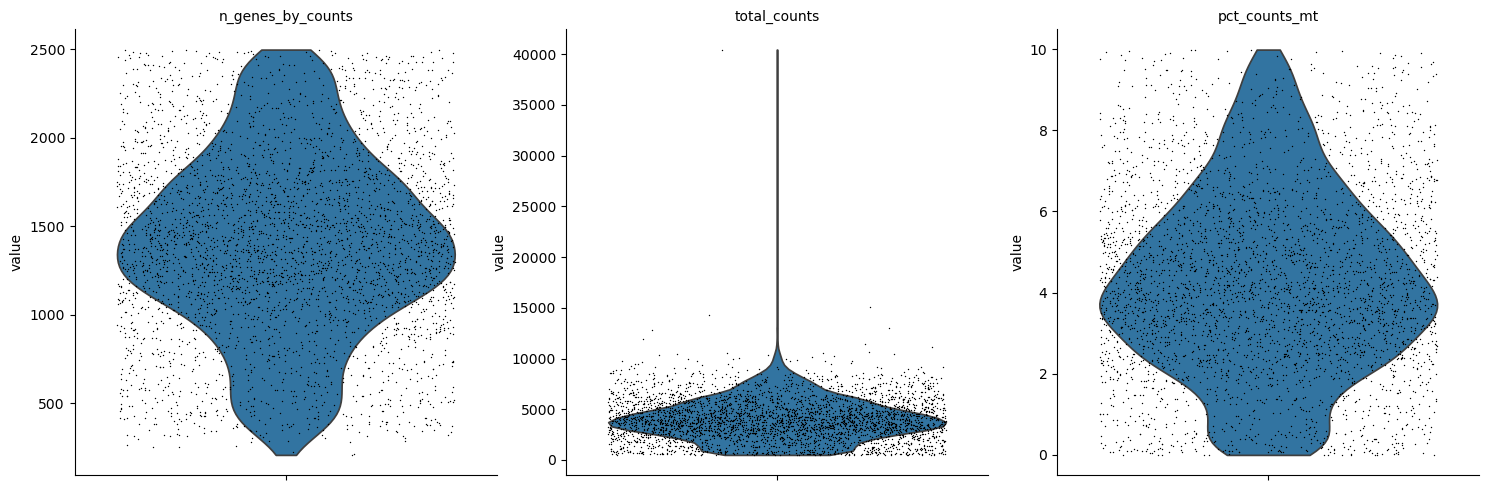

Creating QC violin plot for GSM5910791_Case4-ZY...


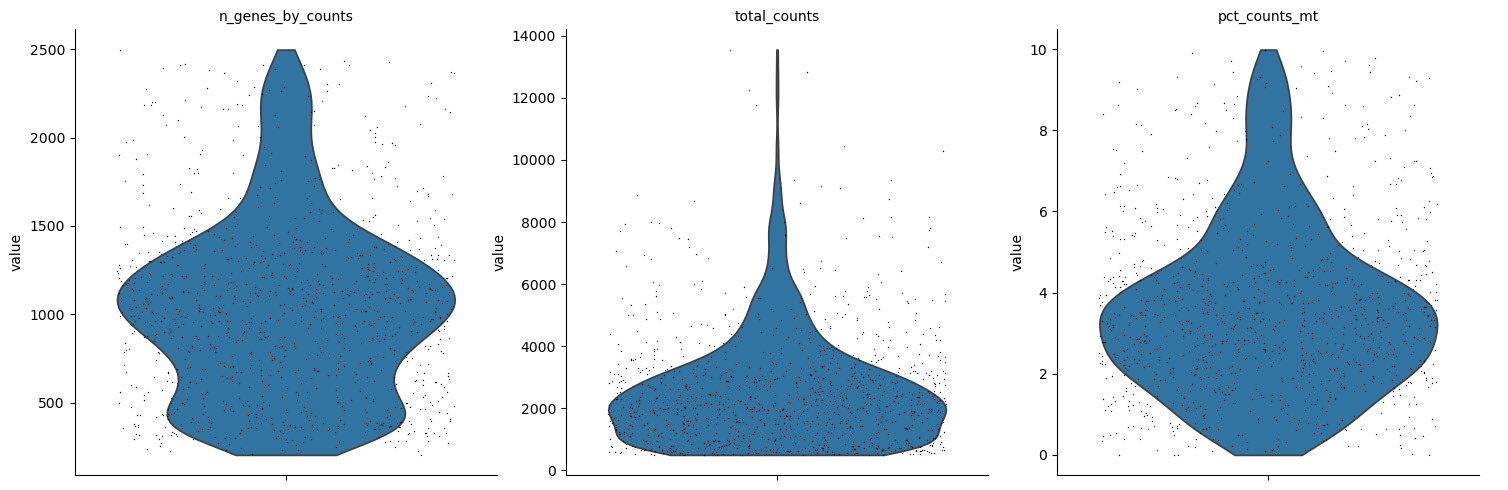

Creating QC violin plot for GSM5910784_Case1-YF...


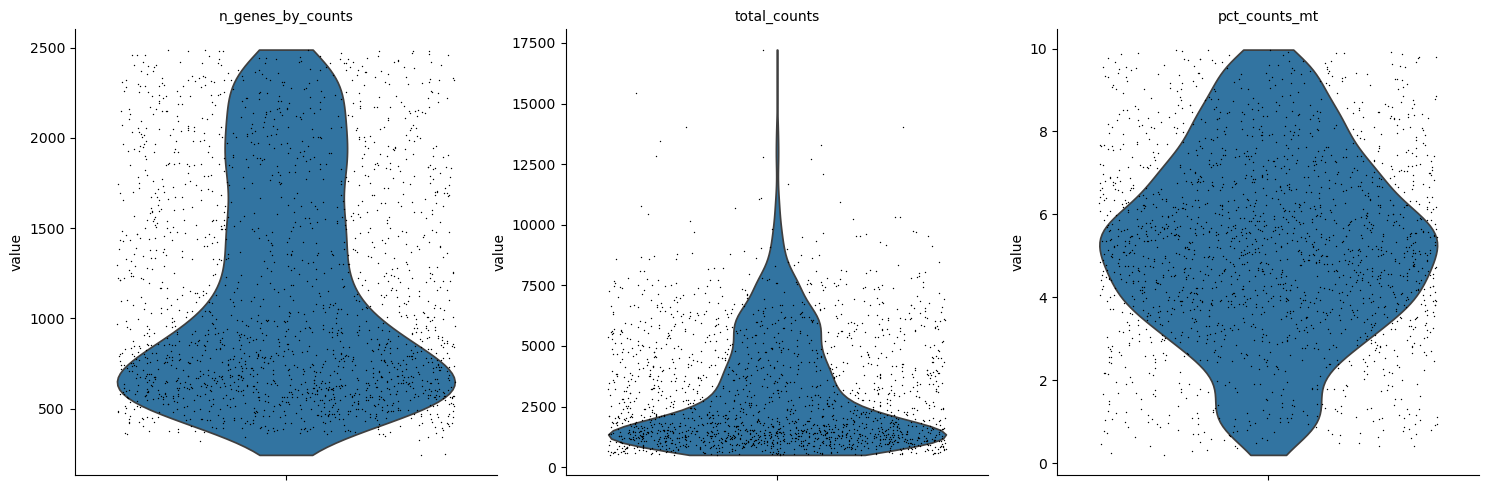

Creating QC violin plot for GSM5910788_Case2-ZY...


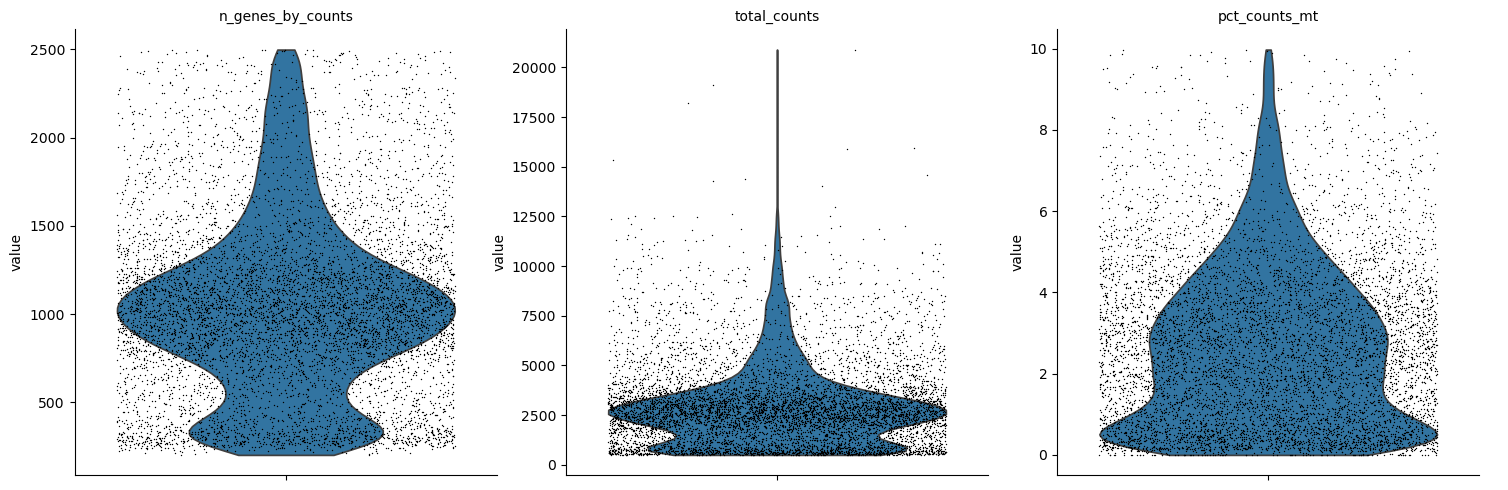

Creating QC violin plot for GSM5910787_Case2-YF...


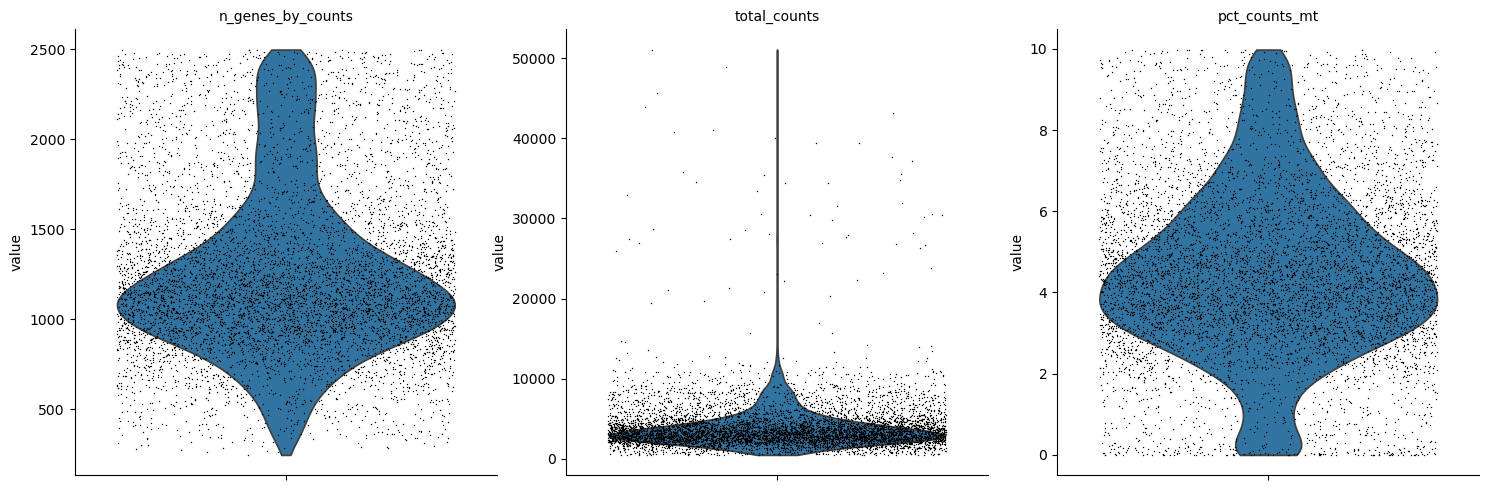

In [62]:
for sample_name, adata in filtered_dict.items():
    print(f"Creating QC violin plot for {sample_name}...")

    sc.pl.violin(
        adata,
        keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
        save=f"_{sample_name}_qc_violin.png"
    )

Running doublet detection for GSM5910789_Case3-YF...
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.8%
Elapsed time: 2.7 seconds
Running doublet detection for GSM5910785_Case1-ZY...
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 2.1 seconds
Running doublet detection for GSM5910786_Case2-ZC...
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.1%
Estimated 

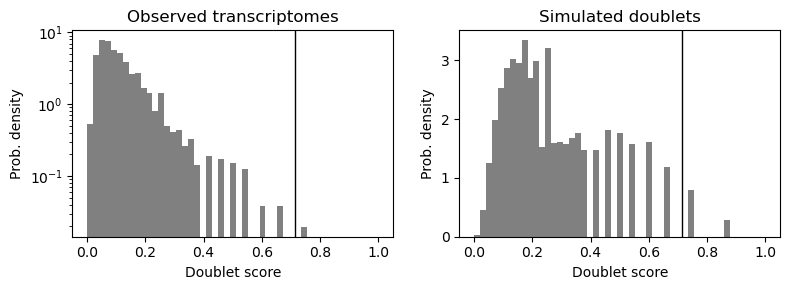

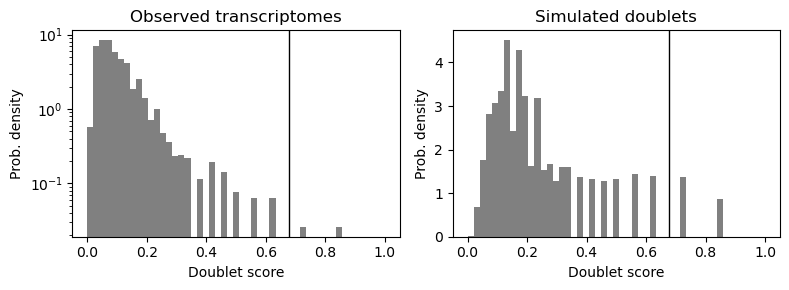

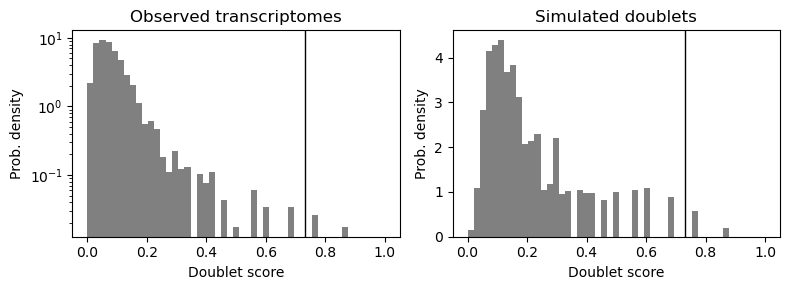

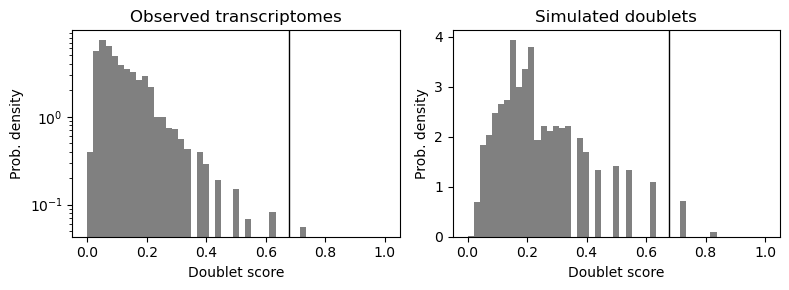

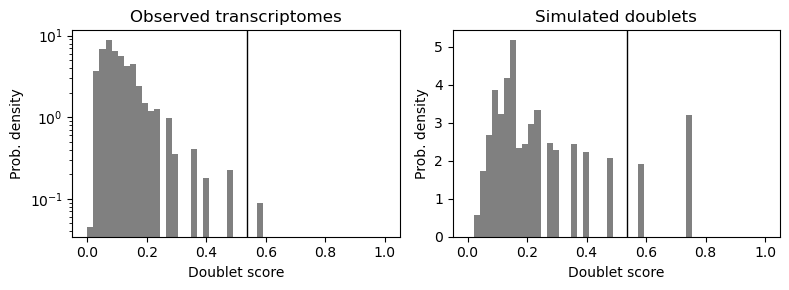

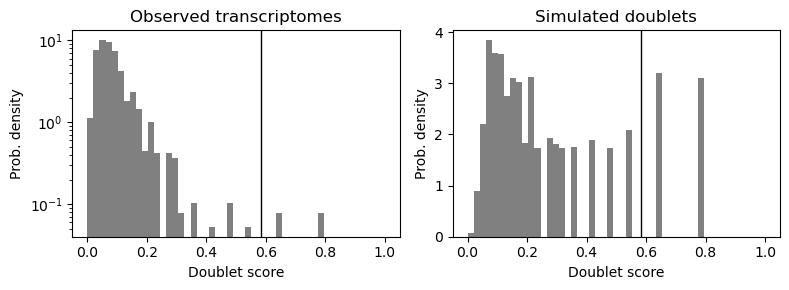

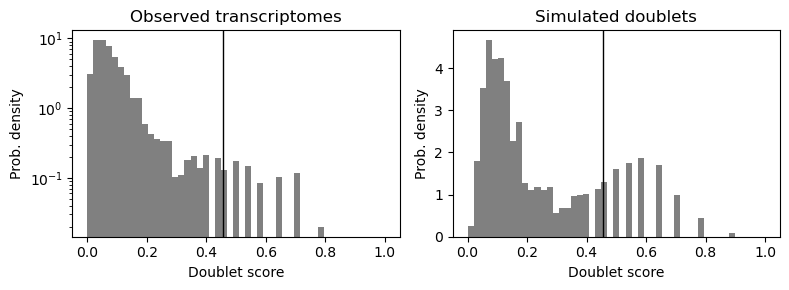

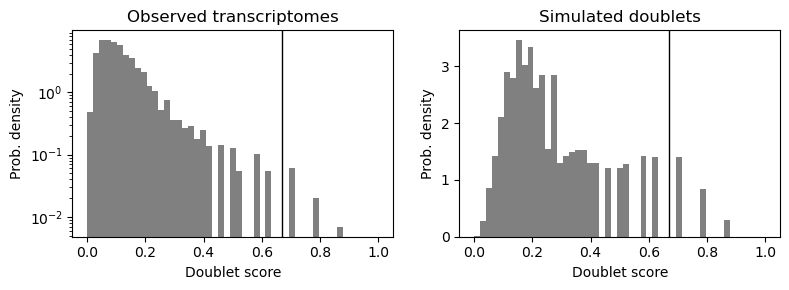

In [6]:
import scrublet as scr

for sample_name, adata in filtered_dict.items():
    print(f"Running doublet detection for {sample_name}...")
    
    scrub = scr.Scrublet(adata.X)  # Initialize Scrublet
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    # Add Scrublet results to AnnData
    adata.obs["doublet_scores"] = doublet_scores
    adata.obs["predicted_doublets"] = predicted_doublets
    
    # Plot histogram of doublet scores
    scrub.plot_histogram()
    plt.savefig(f"{sample_name}_doublet_scores_histogram.png")

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


Creating integrated QC plot for GSM5910789_Case3-YF...


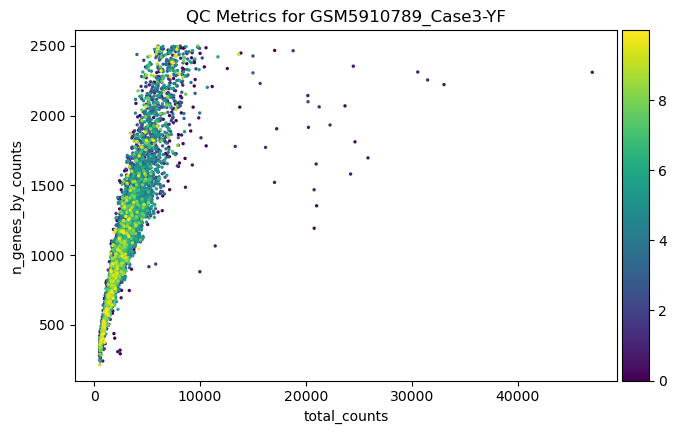

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


Creating integrated QC plot for GSM5910785_Case1-ZY...


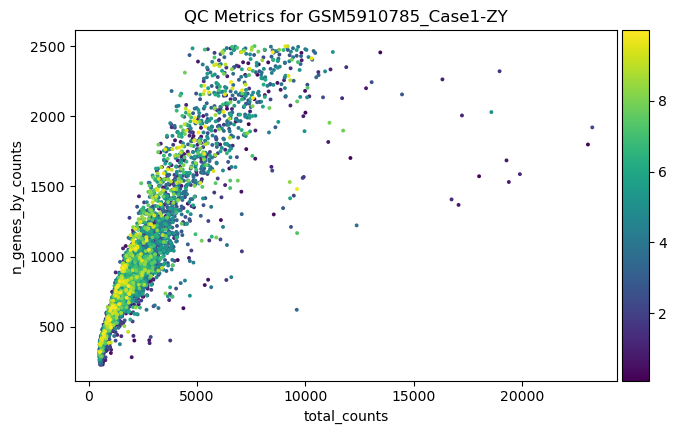

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


Creating integrated QC plot for GSM5910786_Case2-ZC...


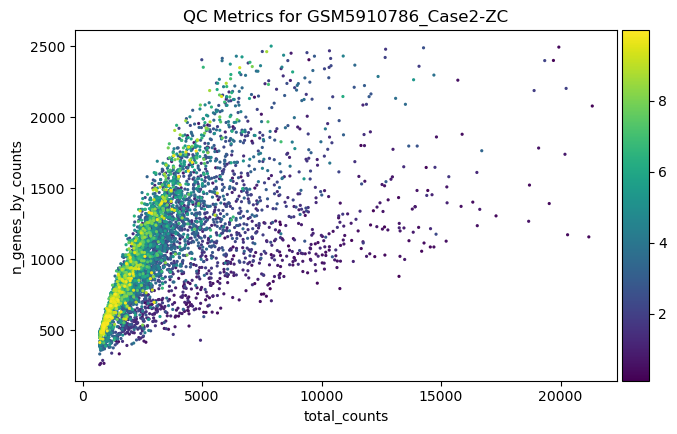

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


Creating integrated QC plot for GSM5910790_Case3-ZY...


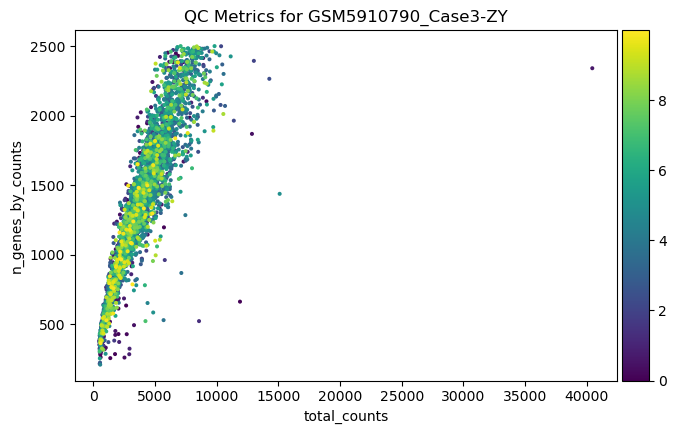

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


Creating integrated QC plot for GSM5910791_Case4-ZY...


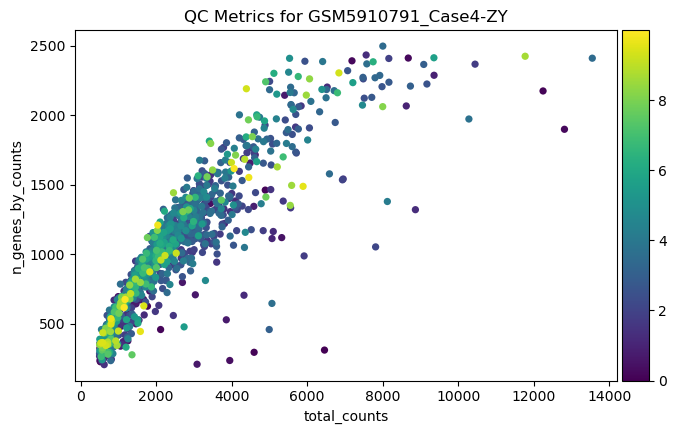

... storing 'sample_id' as categorical


Creating integrated QC plot for GSM5910784_Case1-YF...


... storing 'feature_types' as categorical


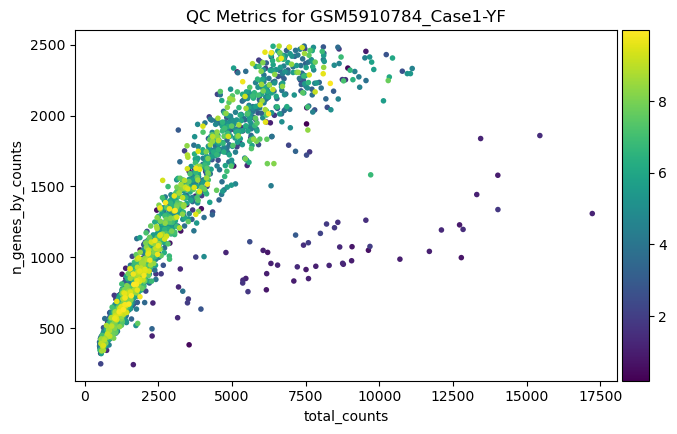

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


Creating integrated QC plot for GSM5910788_Case2-ZY...


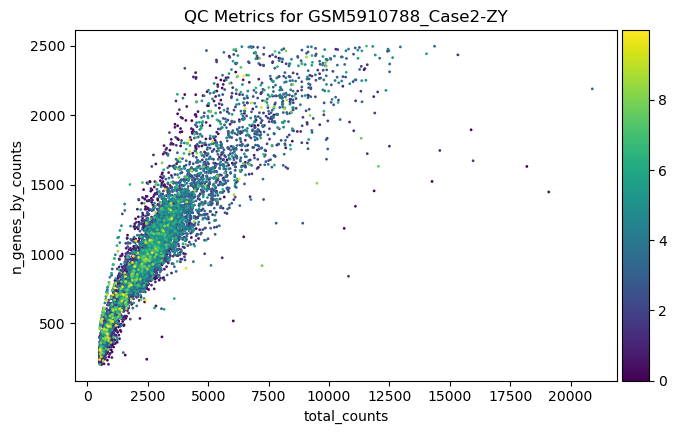

... storing 'sample_id' as categorical
... storing 'feature_types' as categorical


Creating integrated QC plot for GSM5910787_Case2-YF...


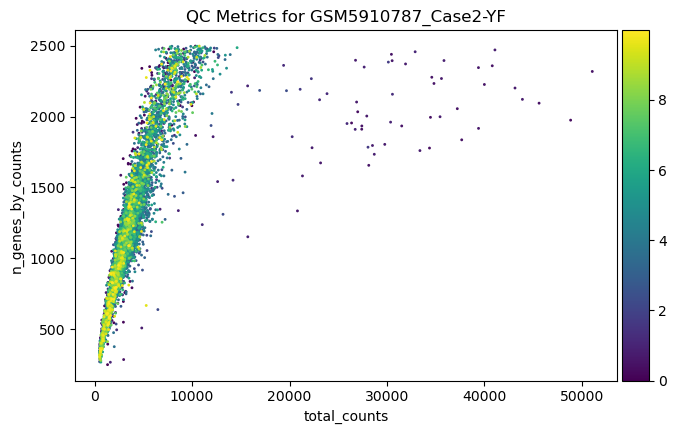

In [7]:
## Joint QC metrics for every sample 
for sample_name, adata in filtered_dict.items():
    print(f"Creating integrated QC plot for {sample_name}...")
    
    # Create a scatter plot matrix
    sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt",
                  title=f"QC Metrics for {sample_name}", save=f"_{sample_name}_qc_integrated.png")

In [8]:
# Create a summary table
summary_data = []
for sample_name in adata_dict.keys():
    before_cells = adata_dict[sample_name].n_obs
    before_genes = adata_dict[sample_name].n_vars
    after_cells = filtered_dict[sample_name].n_obs
    after_genes = filtered_dict[sample_name].n_vars
    
    summary_data.append({
        "Sample": sample_name,
        "Cells Before": before_cells,
        "Genes Before": before_genes,
        "Cells After": after_cells,
        "Genes After": after_genes,
    })

# Convert to a pandas DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the table
print(summary_df)

# Save the table to a CSV file
summary_df.to_csv("qc_summary.csv", index=False)

                Sample  Cells Before  Genes Before  Cells After  Genes After
0  GSM5910789_Case3-YF          9379         33538         5084        33538
1  GSM5910785_Case1-ZY         13685         33538         3818        33538
2  GSM5910786_Case2-ZC          6606         33538         5685        33538
3  GSM5910790_Case3-ZY          8837         33538         3556        33538
4  GSM5910791_Case4-ZY          2024         33538         1095        33538
5  GSM5910784_Case1-YF         21560         33538         1875        33538
6  GSM5910788_Case2-ZY          9406         33538         7543        33538
7  GSM5910787_Case2-YF         11786         33538         7200        33538


#### Preprocessing Discussion 

I used filtering thresholds that removed cells with more than 10% mitochondrial reads and retained cells that had transcript content between the range of 200 to 2500 genes. This ensure that cells with less than 200 genes, which are likely poor quality cells, would be excluded from further analysis and cells with more than 2500 genes are more probable of being doublets i.e. having more than the normal amount of transcripts for a typical cell due to errors in the drop technique that scRNA-Seq uses. I chose 10% for the mitochondrial reads as that is the standard for human cells. If the samples were derived from respiratory tissues, then I would have set the threshold to be less stringent as respiratory tissues have a higher mitocondrial counts, probaby due to the oxidative processes in lungs. However, for pancreas and liver tissues, this was an appropriate threshold. 

The above code chunk prints out the table for the number of genes and cells left after filtering  

In the literature, several objective strategies exist for setting thresholds in single-cell RNA-seq (scRNA-seq) quality control metrics, such as mitochondrial content and minimum/maximum gene counts per cell, without relying on visual inspection of plots. Common approaches include adopting standardized, reference-based thresholds (e.g. 10% mitochondrial content for human samples, 5% for mouse), using quantile or percentile cutoffs derived from the data, and applying machine learning or statistical modeling to optimize thresholds based on classification performance or biological signal retention. Additionally, many computational tools and published guidelines recommend evidence-based default values, enabling reproducible and literature-supported QC filtering without subjective visual assessment.

In [9]:
import anndata as ad

# Combine all samples into a single AnnData object
print("Combining all samples...")
adata_combined = ad.concat(adata_dict, label="sample_id")

# Create a copy for CellTypist annotation
adata_celltypist = adata_combined.copy()

# ✅ Ensure raw counts are preserved before normalization
if "counts" not in adata_celltypist.layers:
    adata_celltypist.layers["counts"] = adata_celltypist.X.copy()

# Check the combined object
print(f"Combined data shape: {adata_combined.shape}")
print(f"Samples combined: {adata_combined.obs['sample_id'].unique()}")


Combining all samples...
Combined data shape: (83283, 33538)
Samples combined: ['GSM5910789_Case3-YF', 'GSM5910785_Case1-ZY', 'GSM5910786_Case2-ZC', 'GSM5910790_Case3-ZY', 'GSM5910791_Case4-ZY', 'GSM5910784_Case1-YF', 'GSM5910788_Case2-ZY', 'GSM5910787_Case2-YF']
Categories (8, object): ['GSM5910789_Case3-YF', 'GSM5910785_Case1-ZY', 'GSM5910786_Case2-ZC', 'GSM5910790_Case3-ZY', 'GSM5910791_Case4-ZY', 'GSM5910784_Case1-YF', 'GSM5910788_Case2-ZY', 'GSM5910787_Case2-YF']


### Normalization 

In [10]:
# Step 1: Save raw counts in a separate layer (only if not already saved)
if "counts" not in adata_combined.layers:
    print("Saving raw counts...")
    adata_combined.layers["counts"] = adata_combined.X.copy()
else:
    print("Raw counts already saved in .layers['counts']")

# Step 2: Normalize total counts per cell (only if not already normalized)
if "total_counts" not in adata_combined.obs.columns:
    print("Normalizing total counts...")
    sc.pp.normalize_total(adata_combined, target_sum=1e4)
else:
    print("Normalization appears to have already been performed.")

# Step 3: Log-transform the data (only if not already log-transformed)
# We check if values are already log1p-transformed using a heuristic
if (adata_combined.X.max() > 100).compute() if hasattr(adata_combined.X, "compute") else adata_combined.X.max() > 100:
    print("Log-transforming normalized data...")
    sc.pp.log1p(adata_combined)
else:
    print("Data appears to be already log-transformed.")

print("✅ Normalization steps completed for the combined dataset.")


Saving raw counts...
Normalization appears to have already been performed.
Log-transforming normalized data...
✅ Normalization steps completed for the combined dataset.


#### Normalization Discussions
This performs normalization and log-transformation on each sample where the raw count matrix (adata.X) is first saved in a separate layer called "counts", preserving the original data for reproducibility or future reprocessing.
Next, total count normalization is applied using sc.pp.normalize_total(), which scales the gene expression values so that each cell has a total count of exactly 10,000. This normalizes to the median library size of cells in the dataset. 
After normalization, a log1p transformation (log(1 + x)) is applied to the normalized data. This transformation compresses large expression values, stabilizes variance, and reduces the influence of highly expressed genes — all of which help in downstream tasks such as dimensionality reduction and clustering. The resulting log-normalized values are stored in a new layer "normalized" to keep both raw and processed data accessible within each AnnData object.

### Feature Selection

Identifying highly variable genes...
Highly variable genes: 2000
Non-variable genes: 31538
Plotting highly variable genes...


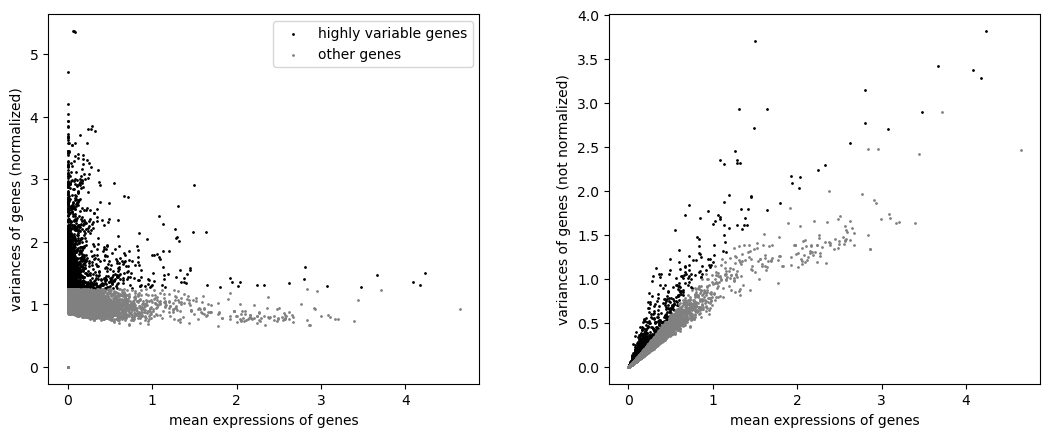

In [11]:
# Step 1: Perform HVG selection only if not already done
if "highly_variable" not in adata_combined.var.columns:
    print("Identifying highly variable genes...")
    sc.pp.highly_variable_genes(
        adata_combined,
        flavor="seurat_v3",   # Use Seurat v3 HVG selection
        n_top_genes=2000,
        subset=False
    )
else:
    print("Highly variable genes already computed.")

# Step 2: Count HVGs and non-HVGs
if "highly_variable" in adata_combined.var.columns:
    hvg_count = adata_combined.var["highly_variable"].sum()
    non_hvg_count = adata_combined.shape[1] - hvg_count
    print(f"Highly variable genes: {hvg_count}")
    print(f"Non-variable genes: {non_hvg_count}")
else:
    print("Warning: HVGs not found. Cannot summarize counts.")

# Step 3: Plot HVGs (only if not already saved)
plot_path = "figures/combined_hvg_plot.png"  # Feel free to adjust
if not os.path.exists(plot_path):
    print("Plotting highly variable genes...")
    sc.pl.highly_variable_genes(
        adata_combined,
        save="_combined_hvg_plot.png"
    )
else:
    print("HVG plot already exists. Skipping plot generation.")


In [12]:
## COMBINED

# Calculate the number of total, highly variable, and non-variable genes for the combined dataset
print("Processing the combined dataset...")

# Total number of genes
total_genes = adata_combined.shape[1]

# Number of highly variable genes
highly_variable_genes = adata_combined.var["highly_variable"].sum()

# Number of non-variable genes
non_variable_genes = total_genes - highly_variable_genes

# Print results
print(f"Total genes: {total_genes}")
print(f"Highly variable genes: {highly_variable_genes}")
print(f"Non-variable genes: {non_variable_genes}")


Processing the combined dataset...
Total genes: 33538
Highly variable genes: 2000
Non-variable genes: 31538


#### Feature Selection Discussion

To identify highly variable features (HVGs) in my dataset, I used the sc.pp.highly_variable_genes function from Scanpy with the "seurat_v3" method. This approach is commonly used for single-cell RNA-seq data because it accounts for technical noise while highlighting genes with meaningful biological variability. I chose to select the top 3,000 highly variable genes, which I found to be a good balance for my dataset of around 30,000 genes—capturing important biological signals without introducing too much noise or increasing computational complexity. For this step, I used the raw counts stored in adata.layers["counts"] to ensure the variability calculation was not biased by normalization or log transformation.

Out of a total of 33538 genes, 3000 genes were considered highly variable while 30538 genes were not. 

### PCA

Performing PCA on the combined dataset...
Plotting explained variance ratio for the top 50 PCs...


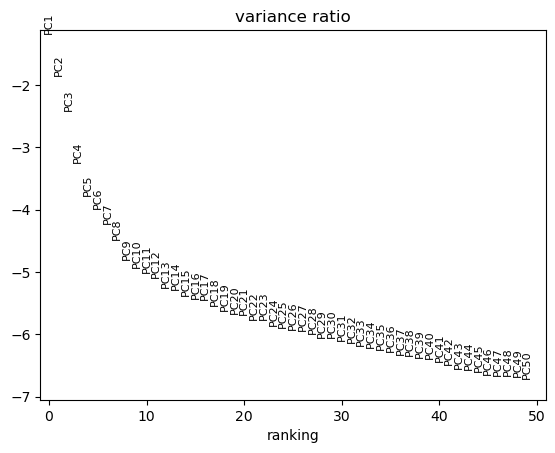

In [13]:
import os

# Step 1: Perform PCA only if not already computed
if "X_pca" not in adata_combined.obsm:
    print("Performing PCA on the combined dataset...")
    sc.tl.pca(adata_combined)
else:
    print("PCA already computed. Skipping.")

# Step 2: Plot PCA variance ratio (elbow plot) if not already saved
plot_path = "figures/combined_top50_pcs_variance_ratio.png"  # adjust if needed
if not os.path.exists(plot_path):
    print("Plotting explained variance ratio for the top 50 PCs...")
    sc.pl.pca_variance_ratio(
        adata_combined,
        n_pcs=50,
        log=True,
        save="_top50_pcs_variance_ratio.png"
    )
else:
    print("Variance ratio plot already exists. Skipping plot.")


#### PCA Justification and plot
Picking the first 10 PCs for downstream analysis as thats where the inflection point appears in the plot. 

### CLustering

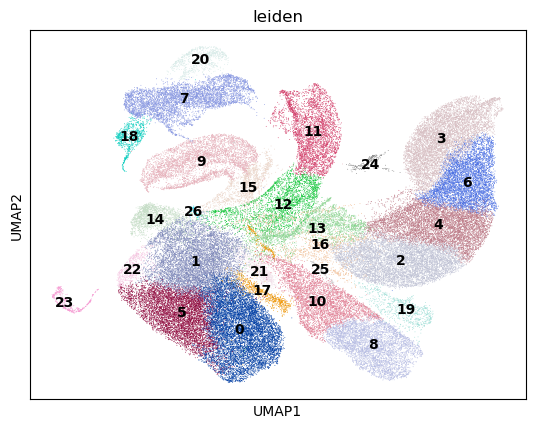

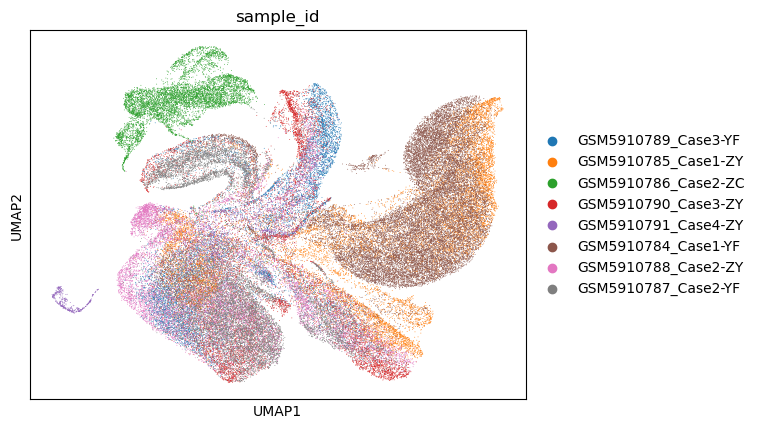

In [14]:
# Use the first 10 PCs for neighborhood graph construction
sc.pp.neighbors(adata_combined, n_pcs=10)
# Compute UMAP
sc.tl.umap(adata_combined)
## CLUSTERING
# Perform clustering using the Leiden algorithm
sc.tl.leiden(adata_combined, resolution=0.6)  
sc.pl.umap(adata_combined, color="leiden", legend_loc="on data", save="_clusters.png")
## TO SEE SAMPLE IDS
# UMAP plot colored by sample ID
sc.pl.umap(adata_combined, color="sample_id", legend_loc="right margin", save="_samples.png")



As see in the plot above, Normal Pancreas Tissue clusters separately. 

In [50]:
## NO. of cells 

# Get the total number of cells (points) from the AnnData object
num_points = adata_combined.n_obs

# Print the result
print(f"Number of points (cells) on the UMAP plot: {num_points}")

Number of points (cells) on the UMAP plot: 83283


As see in the plot above, Normal Pancreas Tissue clusters separately. 
83283 cells, 14 clusters, resolution 0.6
The UMAP plots reveal robust clustering of cells based on both transcriptomic identity and sample origin. In the first plot, clustering by Leiden algorithm identifies 27 transcriptionally distinct clusters, suggesting a high degree of cellular heterogeneity in the dataset. Several clusters are compact and well-separated, indicating strong intra-cluster similarity and potentially distinct cell types or states.

In the second plot, cells are colored by sample ID, showing that while there is some degree of sample-specific segregation (e.g., green cells from Case2-ZC occupy the top-left), many clusters are shared across multiple samples. This indicates successful integration of datasets from different patients and tissue conditions (normal, primary tumor, and metastasis), with clusters likely reflecting conserved cell populations rather than batch effects. However, a few clusters appear enriched for specific samples (e.g., cluster 18 is mostly from Case2-ZC), which could reflect tissue-specific or patient-specific cell types - which is expected as they're normal tissue type, or condition-specific states such as immune activation in metastases.

Overall, the clustering demonstrates both shared and condition-specific cellular identities across the pancreatic and hepatic tumor microenvironments. 

### Marker Gene Analysis

In [16]:
# Step 1: Perform marker gene analysis using Wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata_combined, groupby="leiden", method="wilcoxon")


/opt/anaconda3/envs/scRNAseq/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/anaconda3/envs/scRNAseq/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/anaconda3/envs/scRNAseq/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFram

In [17]:
top_markers = []
clusters = adata_combined.uns["rank_genes_groups"]["names"].dtype.names
for cluster in clusters:
    df = sc.get.rank_genes_groups_df(adata_combined, group=cluster)
    top5 = df.head(5)
    top5["cluster"] = cluster
    top_markers.append(top5)
top_markers_df = pd.concat(top_markers, ignore_index=True)
print(top_markers_df)

/var/folders/d0/6g717t515ldb_mh_wy7cd8y80000gn/T/ipykernel_13563/3164010205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5["cluster"] = cluster
/var/folders/d0/6g717t515ldb_mh_wy7cd8y80000gn/T/ipykernel_13563/3164010205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5["cluster"] = cluster
/var/folders/d0/6g717t515ldb_mh_wy7cd8y80000gn/T/ipykernel_13563/3164010205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

       names      scores  logfoldchanges         pvals     pvals_adj cluster
0      CXCR4  131.511047        3.851648  0.000000e+00  0.000000e+00       0
1       CREM  109.972595        3.198604  0.000000e+00  0.000000e+00       0
2       BTG1  108.684090        2.353553  0.000000e+00  0.000000e+00       0
3       SRGN  108.587234        2.916291  0.000000e+00  0.000000e+00       0
4    TNFAIP3  107.368057        2.793082  0.000000e+00  0.000000e+00       0
..       ...         ...             ...           ...           ...     ...
130     MZB1    7.884246        5.440877  3.164413e-15  8.910444e-13      26
131   JCHAIN    7.697083        5.563694  1.392077e-14  3.383151e-12      26
132     IGKC    7.014352        6.347124  2.310171e-12  3.635986e-10      26
133    IGHG1    7.005963        7.005919  2.452933e-12  3.826348e-10      26
134    DERL3    6.067373        3.592346  1.300193e-09  1.207919e-07      26

[135 rows x 6 columns]


/var/folders/d0/6g717t515ldb_mh_wy7cd8y80000gn/T/ipykernel_13563/3164010205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5["cluster"] = cluster
/var/folders/d0/6g717t515ldb_mh_wy7cd8y80000gn/T/ipykernel_13563/3164010205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5["cluster"] = cluster
/var/folders/d0/6g717t515ldb_mh_wy7cd8y80000gn/T/ipykernel_13563/3164010205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

#### MGA Discussion
To identify marker genes distinguishing each cell cluster, we used the Wilcoxon rank-sum test, a non-parametric method implemented via Scanpy’s rank_genes_groups() function. This test compares gene expression levels in one cluster versus all other clusters, ranking genes based on their statistical significance and effect size. After running the test using Leiden cluster labels, we extracted the top five marker genes per cluster into a single dataframe. These genes represent transcripts most enriched in each cluster, offering insight into the potential identity or functional state of the cell populations.

One of the key strengths of the Wilcoxon rank-sum test is its non-parametric nature, meaning it does not assume normal distribution of gene expression which is a valuable property when analyzing sparse and zero-inflated single-cell RNA-seq data. It is also robust to outliers, as it works on the ranks of expression values rather than their raw magnitudes. These features make it a commonly used method in scRNA-seq pipelines for identifying genes that are strongly differentially expressed in a specific group of cells. The simplicity and interpretability of the output (including gene name, fold change, and p-value) further make it practical for exploratory and comparative analyses.

However, the Wilcoxon method also comes with limitations. It performs univariate comparisons, treating each gene independently, and therefore does not account for correlated expression patterns or multivariate structures within the data. Additionally, it relies on a one-vs-rest comparison, which might obscure subtle but biologically relevant differences between similar clusters. The method’s sensitivity can also be affected by uneven cluster sizes, leading to reduced power in small groups or exaggerated differences in large ones. Despite these caveats, when used in conjunction with robust clustering and proper QC filtering, the Wilcoxon test remains an effective tool for preliminary marker discovery in single-cell analysis.

### Automatic Annotation of Clusters

🔬 Input data has 83283 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 1861 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


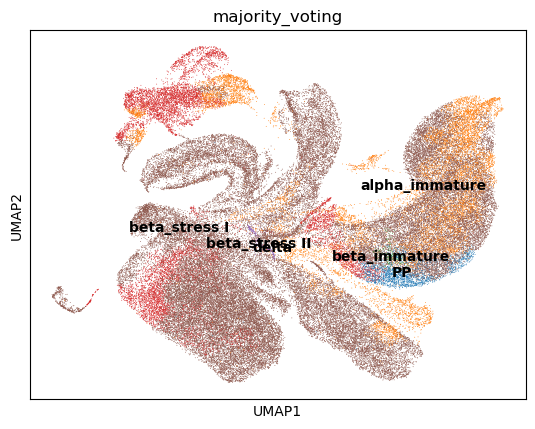

In [19]:
import celltypist

# Make a copy to work with
adata_celltypist = adata_combined.copy()

# Ensure raw counts are available
if "counts" not in adata_celltypist.layers:
    adata_celltypist.layers["counts"] = adata_celltypist.X.copy()

# Normalize and log-transform for annotation
sc.pp.normalize_total(adata_celltypist, target_sum=10000)
sc.pp.log1p(adata_celltypist)
adata_celltypist.obs_names_make_unique()
adata_celltypist.var_names_make_unique()

# Annotate using CellTypist (choose model based on species)
predictions = celltypist.annotate(
    adata_celltypist,
    model="Adult_Human_PancreaticIslet.pkl",  # Adjust as needed
    majority_voting=True
)

# Merge predictions into AnnData object
adata_combined.obs = adata_combined.obs.join(predictions.predicted_labels, rsuffix="_ct")

# Visualize UMAP with labels
sc.pl.umap(
    adata_combined,
    color= "majority_voting",
    legend_loc="on data",
    save="_celltypist_labels.png"
)


CellTypist is a machine learning-based tool designed for automated cell type annotation in single-cell RNA sequencing data. It uses logistic regression models trained on curated reference datasets that encompass a wide range of tissues and cell types. During annotation, CellTypist compares the gene expression profile of each cell in the input dataset to these reference models and assigns the most probable cell identity. It also supports majority voting, which improves robustness by summarizing predictions across clusters rather than individual cells. This approach reduces noise and provides clearer biological interpretation of the data.
Cross-tissue immune cell analysis reveals tissue-specific features in humans. Science 376, eabl5197 (2022).

In this analysis, CellTypist identified several endocrine cell types, including “beta_stress,” “beta_immature_PP,” and “alpha_immature,” which are consistent with the expected cellular composition of the pancreas. These labels suggest the presence of insulin-producing beta cells under stress conditions, as well as immature alpha and PP (pancreatic polypeptide) cells, pointing to a heterogeneous islet population possibly undergoing physiological or pathological remodeling. Given that the dataset includes primary pancreatic tumors and hepatic metastases, it is likely that these endocrine cell populations originate from the primary pancreatic tissues, while immune and stromal cells may reflect contributions from both pancreatic and metastatic liver samples. The annotation aligns well with known cell type distributions in these tissues and supports the biological integrity of the clustering and classification results.

### Manual Annotation 

In [24]:
print(top_markers_df.head(10))

     names      scores  logfoldchanges  pvals  pvals_adj cluster
0    CXCR4  131.511047        3.851648    0.0        0.0       0
1     CREM  109.972595        3.198604    0.0        0.0       0
2     BTG1  108.684090        2.353553    0.0        0.0       0
3     SRGN  108.587234        2.916291    0.0        0.0       0
4  TNFAIP3  107.368057        2.793082    0.0        0.0       0
5    PTPRC   46.001762        1.142497    0.0        0.0       1
6     CCL5   45.975746        1.728054    0.0        0.0       1
7      CD2   43.132523        1.588847    0.0        0.0       1
8     CD69   41.497601        1.344426    0.0        0.0       1
9     CD3D   39.443634        1.475805    0.0        0.0       1


In [25]:
cluster_counts = adata_combined.obs["leiden"].value_counts().sort_values(ascending=False)
print(cluster_counts)

leiden
0     9064
1     7035
2     6652
3     6565
4     6431
5     6082
6     5151
7     5085
8     4276
9     4240
10    3995
11    3756
12    2693
13    2473
14    1862
15    1421
16    1183
17     955
18     783
19     779
20     744
21     740
22     530
23     407
24     196
25     133
26      52
Name: count, dtype: int64


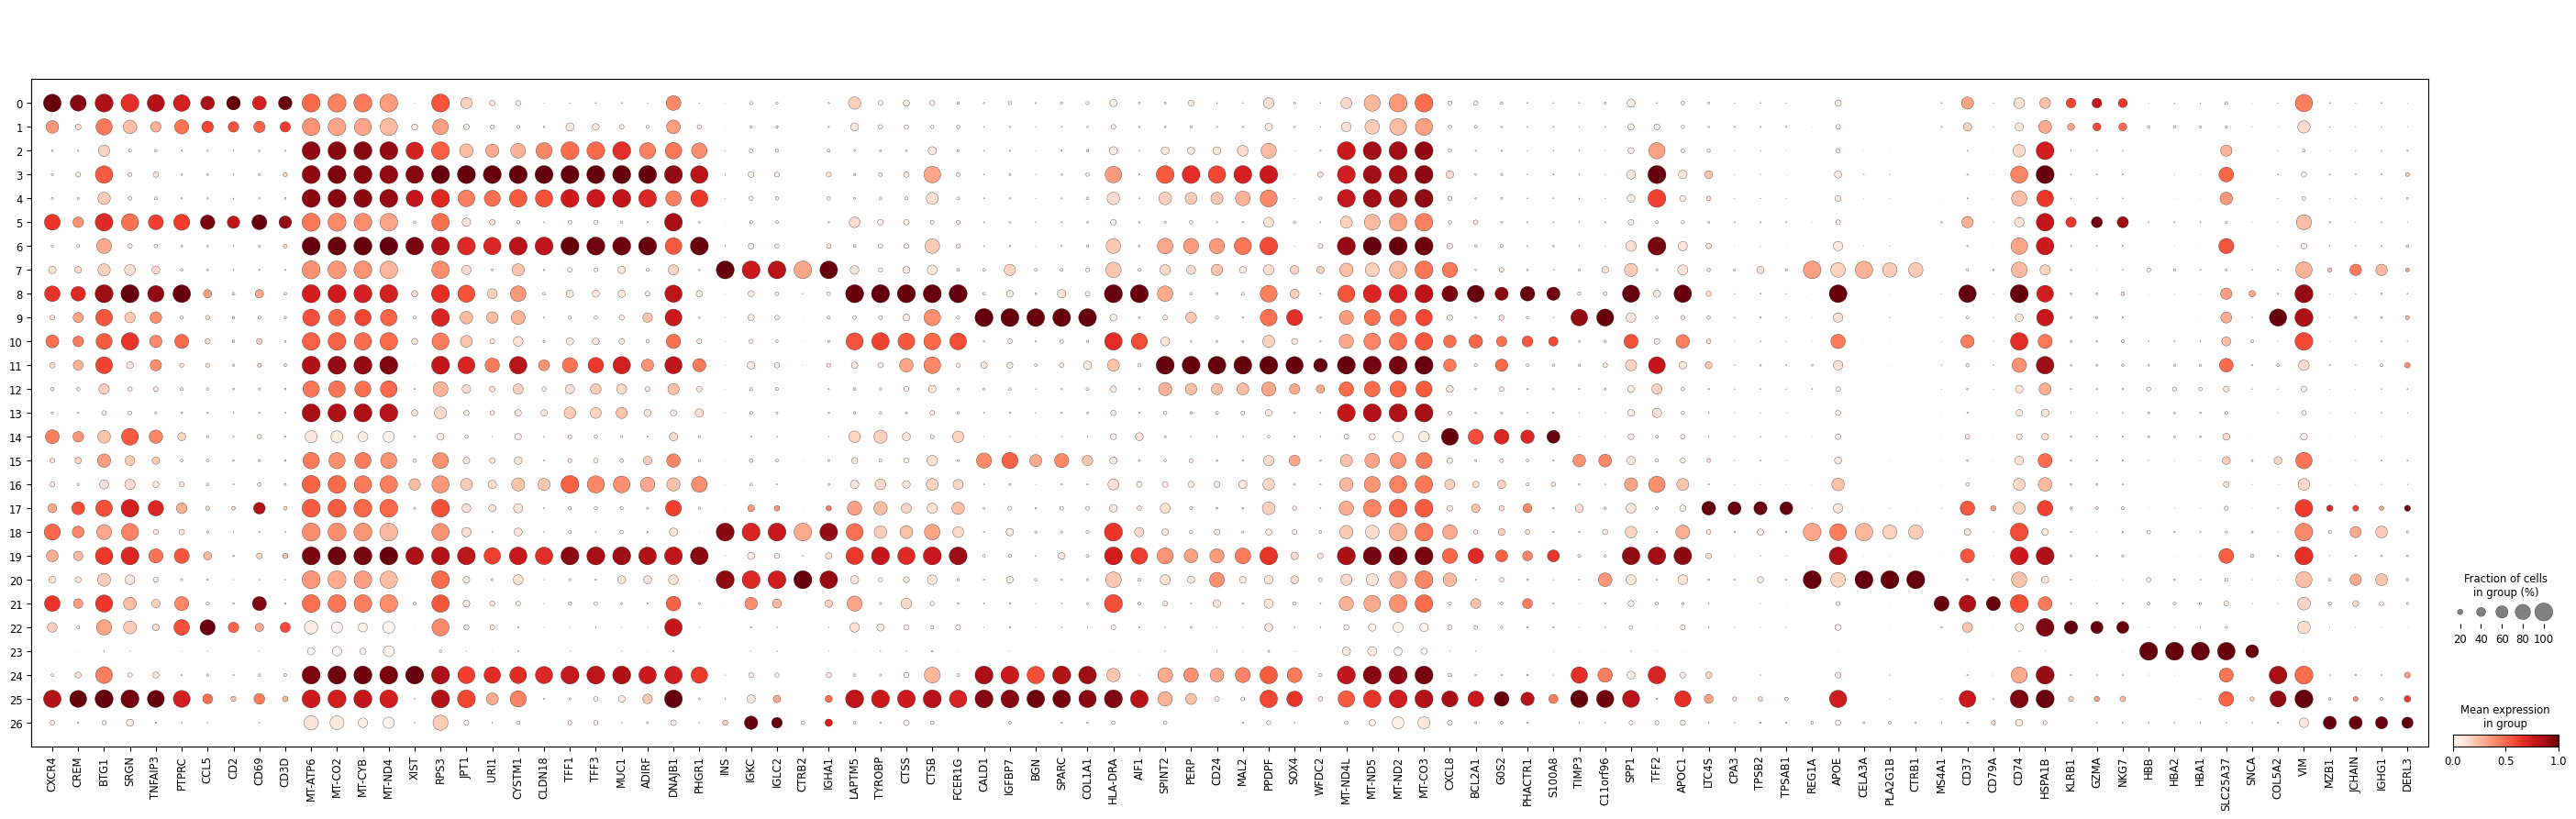

In [26]:
sc.pl.dotplot(
    adata_combined,
    var_names=top_markers_df.groupby("cluster").head(5)["names"].unique().tolist(),
    groupby="leiden",
    standard_scale='var',  # Normalize expression across genes
    save="_top_markers_dotplot.png"
)

In [27]:
top_clusters = cluster_counts.head(3).index.tolist()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

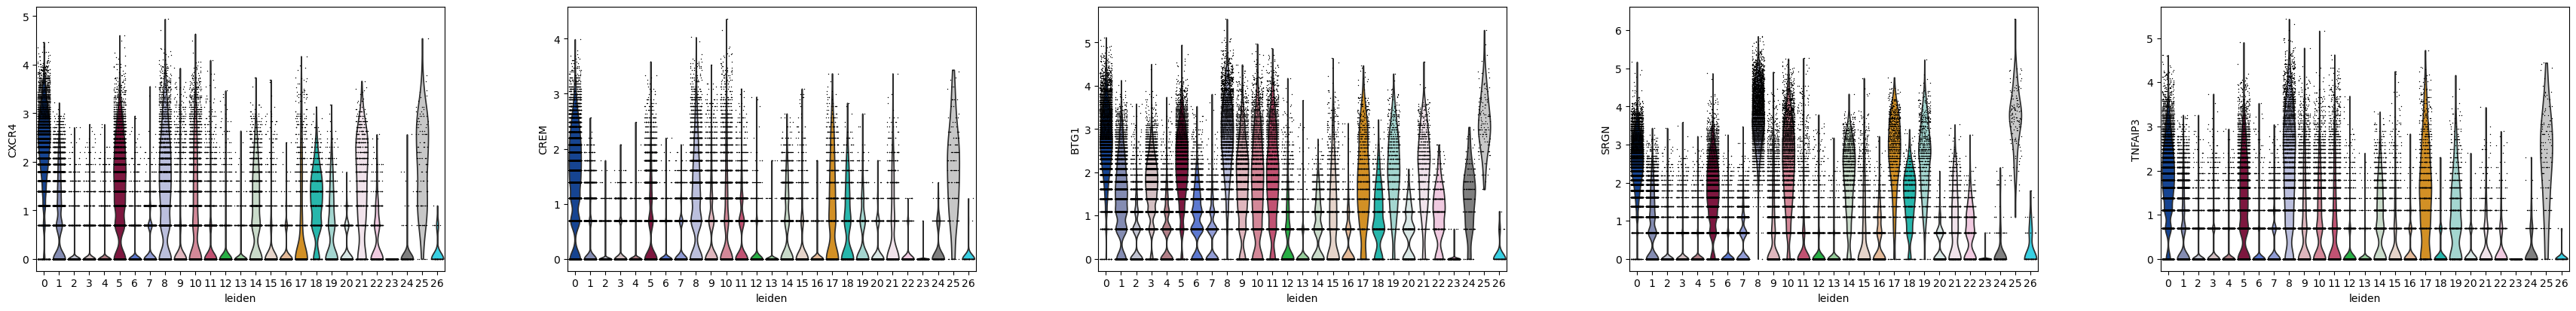

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

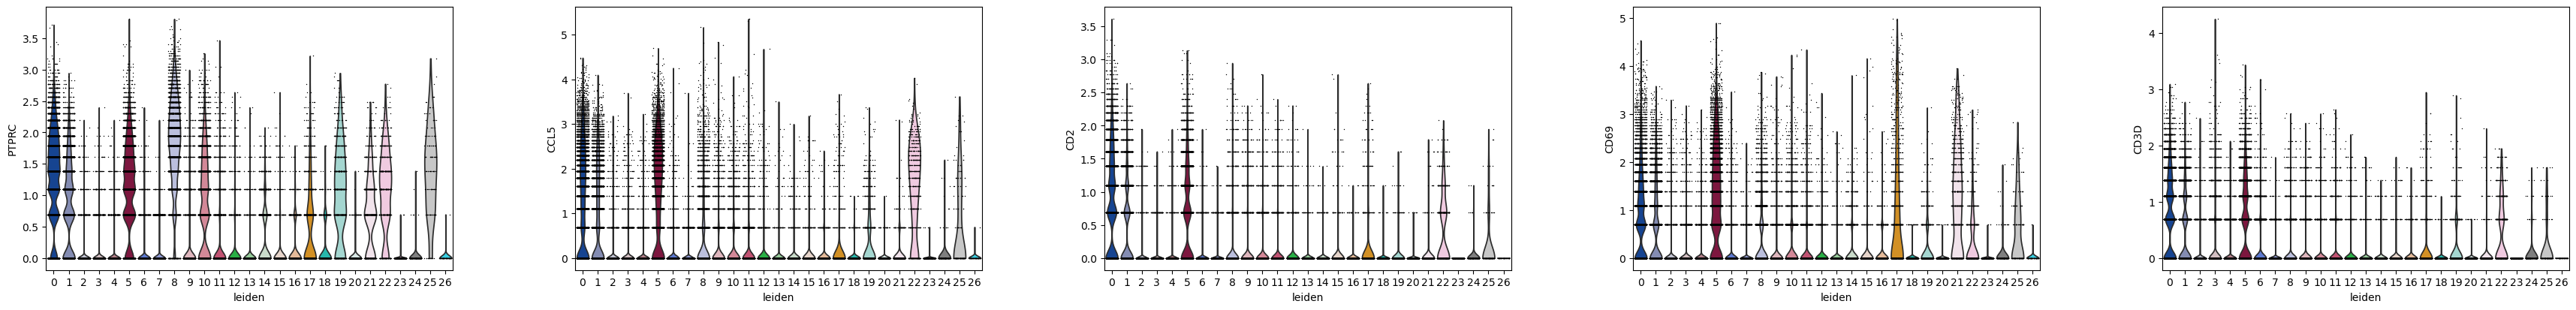

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

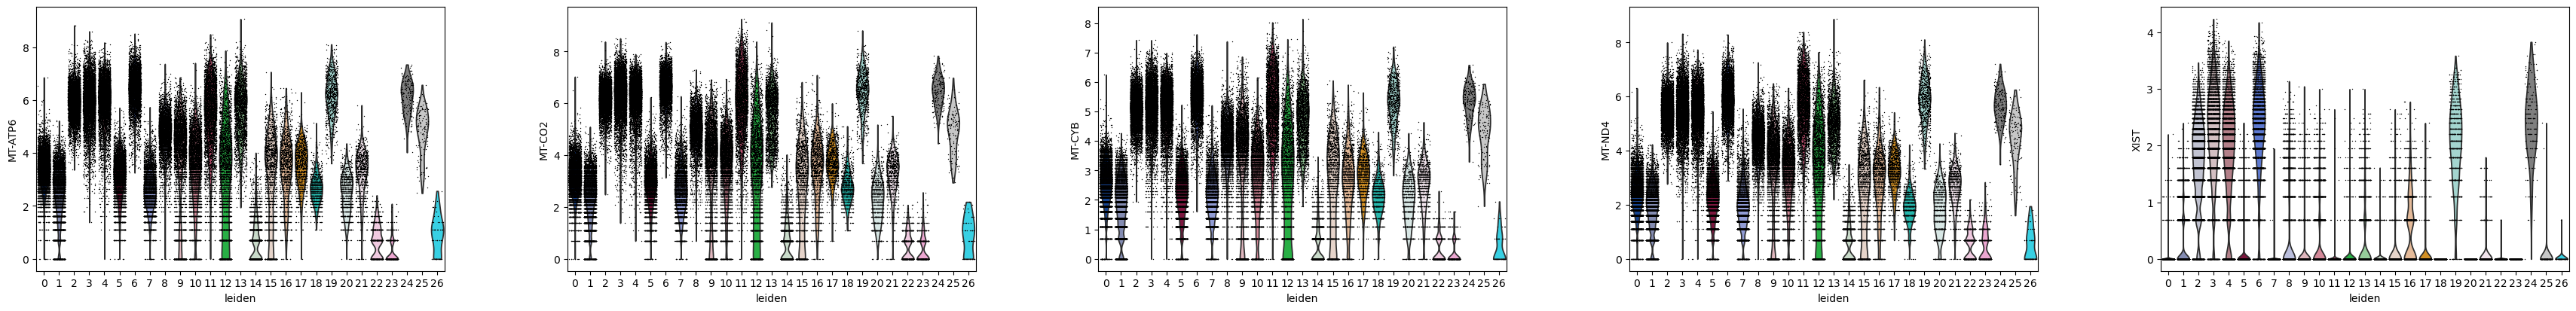

In [49]:
import warnings
for cluster in top_clusters:
    genes = top_markers_df[top_markers_df["cluster"] == cluster].head(5)["names"].tolist()
    sc.pl.violin(
        adata_combined,
        keys=genes,
        groupby="leiden",
        jitter=0.4,
        stripplot=True,
        save=f"_violin_cluster_{cluster}.png"
    )

In [34]:
# performed literature searches for each of every cluster
top_marker_per_cluster = top_markers_df.groupby("cluster").first().reset_index()
print(top_marker_per_cluster)


   cluster    names      scores  logfoldchanges          pvals      pvals_adj
0        0    CXCR4  131.511047        3.851648   0.000000e+00   0.000000e+00
1        1    PTPRC   46.001762        1.142497   0.000000e+00   0.000000e+00
2       10   TYROBP   87.169983        4.186024   0.000000e+00   0.000000e+00
3       11   SPINT2  101.200928        5.354479   0.000000e+00   0.000000e+00
4       12     SOX4   25.977615        1.577752  8.867811e-149  1.351858e-146
5       13  MT-ND4L   40.017345        1.648847   0.000000e+00   0.000000e+00
6       14    CXCL8   58.195564        4.586737   0.000000e+00   0.000000e+00
7       15   IGFBP7   47.972134        4.204268   0.000000e+00   0.000000e+00
8       16     TFF1   25.043703        1.779906  2.044648e-138  4.602242e-136
9       17     SRGN   35.397060        2.896996  1.894886e-274  6.355069e-270
10      18      INS   44.745956        5.864737   0.000000e+00   0.000000e+00
11      19   FCER1G   43.106396        5.295188   0.000000e+00  

In [30]:
manual_annotations = {
    "0": "T cells (CXCR4)",
    "1": "Leukocytes (PTPRC/CD45)",
    "2": "Mitochondrial-rich cells (MT-ATP6)",
    "3": "Ribosomal protein-expressing cells (RPS3)",
    "4": "Secretory epithelial cells (TFF1)",
    "5": "Activated T cells (CD69)",
    "6": "Secretory epithelial cells (TFF1)",
    "7": "Beta cells (INS)",
    "8": "Lysosome-associated cells (LAPTM5)",
    "9": "Smooth muscle cells (CALD1)",
    "10": "Myeloid cells (TYROBP)",
    "11": "Epithelial cells (SPINT2)",
    "12": "Progenitor cells (SOX4)",
    "13": "Mitochondrial-rich cells (MT-ND4L)",
    "14": "Inflammatory cells (CXCL8)",
    "15": "Mesenchymal cells (IGFBP7)",
    "16": "Secretory epithelial cells (TFF1)",
    "17": "Immune cells (SRGN)",
    "18": "Beta cells (INS)",
    "19": "Immune cells (FCER1G)",
    "20": "Acinar cells (CELA3A)",
    "21": "B cells (MS4A1/CD20)",
    "22": "T cells (CCL5)",
    "23": "Erythroid cells (HBB)",
    "24": "Fibroblasts (SPARC)",
    "25": "Smooth muscle cells (CALD1)",
    "26": "Plasma cells (MZB1)"
}

... storing 'manual_cell_type' as categorical


Plotting UMAP with manual annotations...


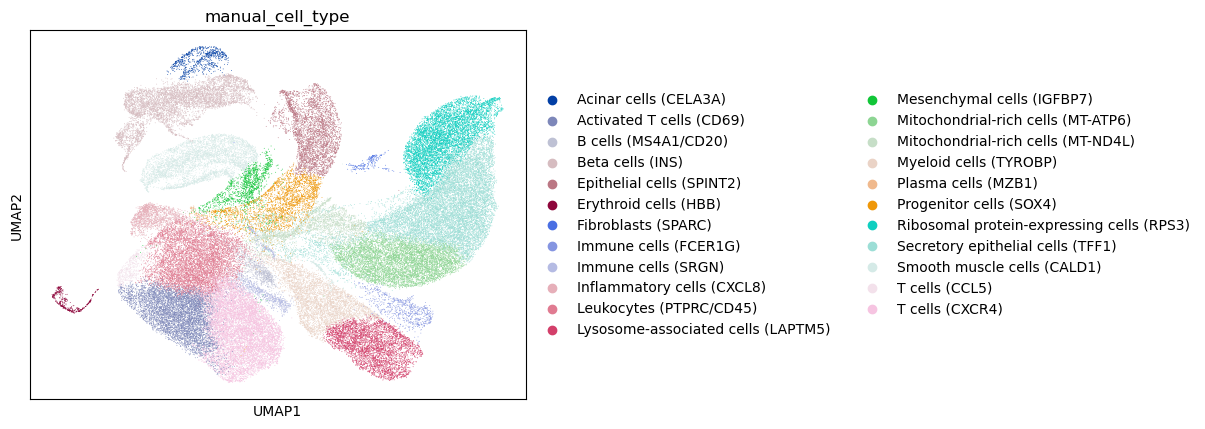

In [33]:
adata_combined.obs["manual_cell_type"] = adata_combined.obs["leiden"].map(manual_annotations)

# Step 2: Plot UMAP only if the file doesn't already exist
import os
plot_path = "figures/umap_manual_annotations.png"  # Adjust path as needed
if not os.path.exists(plot_path):
    print("Plotting UMAP with manual annotations...")
    sc.pl.umap(
        adata_combined,
        color=["manual_cell_type"],
        legend_loc="right margin",
        save="_manual_annotations.png"
    )
else:
    print("Manual annotation plot already exists. Skipping.")

Each cluster of cells was identified by looking at which genes were highly active within that cluster. This was done by combining automated predictions from CellTypist with manual analysis of "marker genes" (genes known to be specific to certain cell types) and information from research papers.

Key findings:

Cluster 0: T cells (based on CXCR4)
Cluster 1: General leukocytes (based on PTPRC/CD45)
Clusters 7 & 18: Pancreatic beta cells (based on INS)
Cluster 21: B cells (based on MS4A1/CD20)
Cluster 23: Erythroid cells (based on HBB)
Cluster 26: Plasma cells (based on MZB1)
Clusters 4, 6, & 16: Secretory epithelial cells (based on TFF1)
Cluster 24: Fibroblasts (based on SPARC)
The researchers cross-referenced these gene-based identifications with existing knowledge to ensure the assigned cell types made sense biologically. The agreement between the automated predictions and the marker gene analysis increased confidence in the final cell type assignments.

for cluster 21: Prevodnik, V.K., Lavrenčak, J., Horvat, M. et al. The predictive significance of CD20 expression in B-cell lymphomas. Diagn Pathol 6, 33 (2011). https://doi.org/10.1186/1746-1596-6-33


## Replications

Tried for cellphone but not compatible
meta = adata_combined.obs[["manual_cell_type"]]  # OR ["leiden"] if you prefer clusters
meta.index.name = "Cell"
meta.columns = ["cell_type"]

Optional: Add sample info (for comparison later)
meta["sample"] = adata_combined.obs["sample_id"]  # Optional 3rd column

Export to tab-delimited file (no header, just two columns)
meta[["cell_type"]].to_csv("cpdb_meta.txt", sep="\t")

Save normalized counts (genes × cells)
counts = pd.DataFrame(
    adata_combined.layers["counts"].T.toarray(),  # transpose to genes × cells
    index=adata_combined.var_names,
    columns=adata_combined.obs_names
)
counts.to_csv("cpdb_counts.txt", sep="\t")

In [41]:
# running cellphonedb - tried but incompatible
#!cellphonedb method statistical_analysis cpdb_meta.txt cpdb_counts.txt --counts-data=gene_name --output-path=cpdb_output

zsh:1: command not found: cellphonedb


# Figure 7g: expression and frequency of representative pro-inflammatory and cytotoxic-mediator genes in NT, PT, and HM samples.

In [43]:
group_map = {
    'GSM5910785_Case1-ZY': 'HM',
    'GSM5910784_Case1-YF': 'PT',
    'GSM5910787_Case2-YF': 'PT',
    'GSM5910788_Case2-ZY': 'HM',
    'GSM5910786_Case2-ZC': 'NT',
    'GSM5910789_Case3-YF': 'PT',
    'GSM5910790_Case3-ZY': 'HM',
    'GSM5910791_Case4-ZC': 'HM',
    # Add any other mappings as needed
}
adata_combined.obs['sample_group'] = adata_combined.obs['sample_id'].map(group_map)

In [47]:
genes = [
    # Cytotoxic mediators
    'GZMA', 'GZMB', 'GZMK', 'GZMH', 'GZMM', 'PRF1', 'GNLY', 'FASLG',
    
    # Pro-inflammatory cytokines
    'IFNG', 'TNF', 'IL2', 'IL21', 'IL12A', 'IL12B', 'IL23A', 'IL1B',
    
    # Chemokines
    'CXCL13',
    
    # Immune checkpoints / exhaustion markers
    'PDCD1', 'CTLA4', 'LAG3', 'TIGIT', 'ICOS', 'TNFRSF4', 'TNFRSF9',
    
    # Transcription factors / signaling
    'JUN', 'STAT1', 'STAT3', 'STAT4', 'STAT6', 'RELA'
]

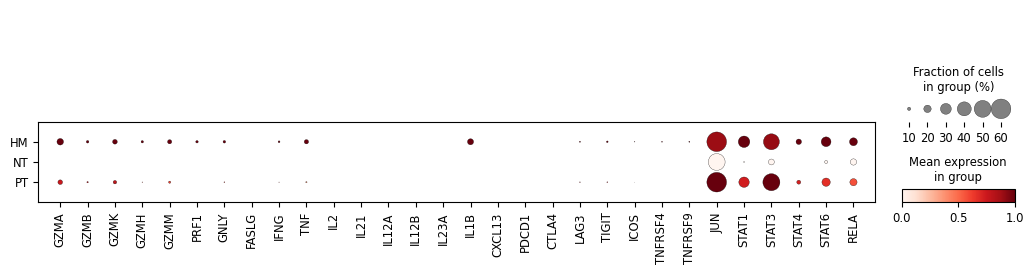

In [48]:
sc.pl.dotplot(
    adata_combined,
    var_names=genes,
    groupby='sample_group',
    standard_scale='var',  # optionally normalize across genes
    cmap='Reds',
    dot_max=0.6,
    dot_min=0.05,
    save="_proinflammatory_dotplot.png"
)

The dot plot reveals distinct patterns in the expression of cytotoxic and pro-inflammatory genes across normal tissue (NT), primary tumor (PT), and hepatic metastasis (HM) samples. Cytotoxic effector molecules such as GZMA, GZMB, and GNLY are more frequently expressed in HM samples, suggesting elevated cytolytic activity within the metastatic microenvironment. In contrast, NT and PT samples show minimal expression of these genes, indicating a suppressed cytotoxic profile in early disease states. Interestingly, the transcription factors STAT1, STAT3, and JUN exhibit strong expression in HM, implying enhanced inflammatory or stress-responsive signaling during metastasis. The checkpoint molecules PDCD1, CTLA4, and LAG3 remain weakly expressed across all tissue types, though CXCL13 which is a chemokine associated with T follicular helper cells and immune exhaustion shows enrichment in HM. Overall, these results suggest that while primary tumors exhibit limited cytotoxic or inflammatory gene expression, the metastatic niche may re-engage immune programs, potentially contributing to altered immune surveillance or tumor–immune interactions.

#### Replication 2: Cell Proportion by Cluster


In [51]:
adata_combined.obs['condition'] = adata_combined.obs['sample_id'].map(
    lambda x: 'NT' if 'NT' in x else 'PT' if 'PT' in x else 'HM'
)

In [52]:
# Create a contingency table of cluster vs condition
proportion_table = pd.crosstab(adata_combined.obs['leiden'], adata_combined.obs['condition'], normalize='columns') * 100

# Optional: convert index to int for sorting
proportion_table.index = proportion_table.index.astype(int)
proportion_table = proportion_table.sort_index()

# Display table
proportion_table.head()

condition         HM
leiden              
0          10.883374
1           8.447102
2           7.987224
3           7.882761
4           7.721864

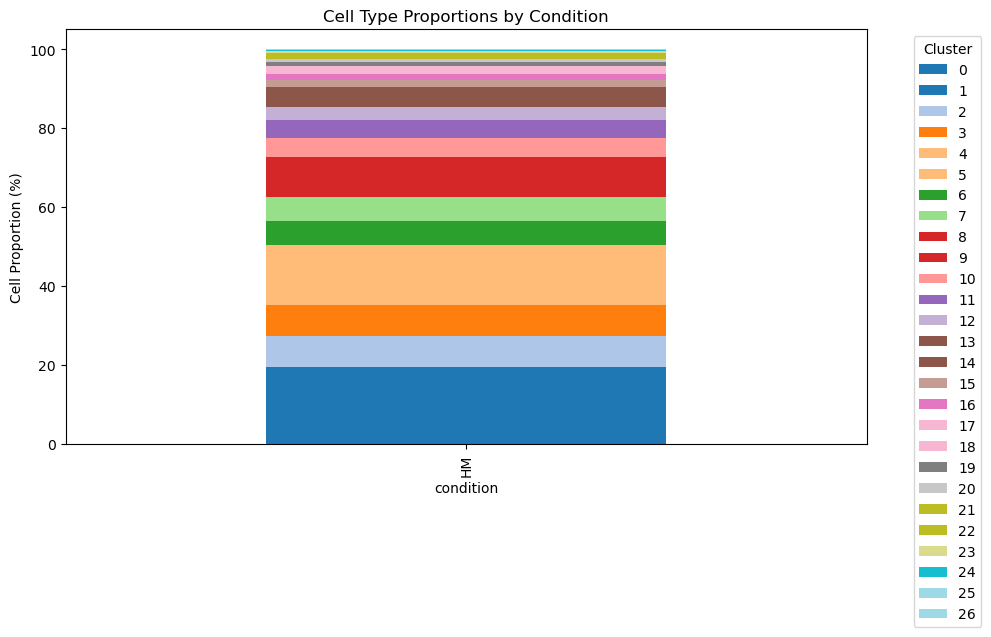

In [53]:
proportion_table.T.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.ylabel('Cell Proportion (%)')
plt.title('Cell Type Proportions by Condition')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster')
plt.tight_layout()
plt.savefig("cell_proportion_by_condition.png")
plt.show()

Based on the plot above and manual annotations, it is reveals that T cells (CXCR4, CCL5) and Activated T cells (CD69) are among the most abundant populations in the hepatic metastasis (HM) sample, suggesting strong immune infiltration. Leukocytes (PTPRC/CD45) and Immune cells (SRGN, FCER1G) also contribute significantly, reinforcing the presence of both adaptive and innate immune activity. Additionally, Secretory epithelial cells (TFF1) and Fibroblasts (SPARC) are present in smaller but notable proportions, consistent with epithelial and stromal remodeling roles. These proportions support the immune-dense microenvironment reported in the original study.

### GSEA ANALYSIS

In [55]:
import gseapy as gp

# For individual clustering - here I picked cluster 0
top_cluster0 = top_markers_df[top_markers_df['cluster'] == '0']['names'].tolist()

# Perform enrichment (using KEGG as an example)
enr = gp.enrichr(gene_list=top_cluster0,
                 gene_sets='KEGG_2021_Human',
                 organism='Human',
                 outdir='enrichr_results',
                 cutoff=0.1)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 28 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'K', 'P', 'a', 'd', 'e', 'hyphen', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 40, 42, 43, 46, 51, 66, 68, 71, 72, 77, 79, 80, 81, 86, 87, 88, 89]
Closed glyph list over 'GSUB': 28 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'K', 'P', 'a', 'd', 'e', 'hyphen', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 40, 42, 43, 46, 51, 66, 68, 71, 72, 77, 79, 80, 81, 86, 87, 88, 89]
Closing glyph list over 'glyf': 28 glyphs before
Glyph names: ['.

<Axes: title={'center': 'KEGG Enrichment for Cluster 0'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

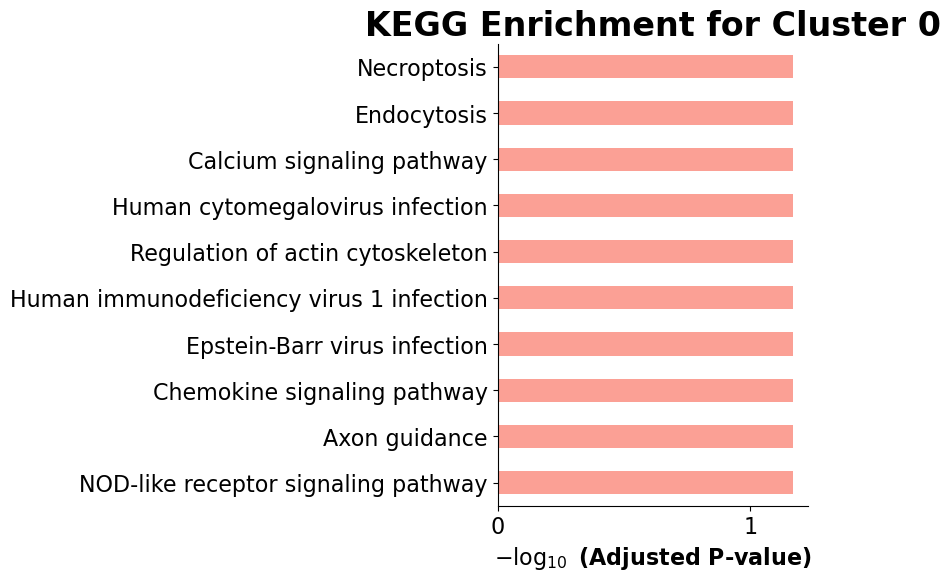

In [57]:
# Plot bar chart of top pathways
gp.barplot(enr.res2d, title='KEGG Enrichment for Cluster 0', cutoff=0.1, top_term=10)


In [59]:
# for cluster 5
# For individual clustering - here I picked cluster 0
top_cluster5 = top_markers_df[top_markers_df['cluster'] == '5']['names'].tolist()

# Perform enrichment (using KEGG as an example)
enr = gp.enrichr(gene_list=top_cluster5,
                 gene_sets='KEGG_2021_Human',
                 organism='Human',
                 outdir='enrichr_results',
                 cutoff=0.1)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 28 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'K', 'P', 'a', 'd', 'e', 'hyphen', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 40, 42, 43, 46, 51, 66, 68, 71, 72, 77, 79, 80, 81, 86, 87, 88, 89]
Closed glyph list over 'GSUB': 28 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'K', 'P', 'a', 'd', 'e', 'hyphen', 'j', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'parenleft', 'parenright', 's', 'space', 't', 'two', 'u', 'underscore', 'v', 'zero']
Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 36, 40, 42, 43, 46, 51, 66, 68, 71, 72, 77, 79, 80, 81, 86, 87, 88, 89]
Closing glyph list over 'glyf': 28 glyphs before
Glyph names: ['.

<Axes: title={'center': 'KEGG Enrichment for Cluster 5'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

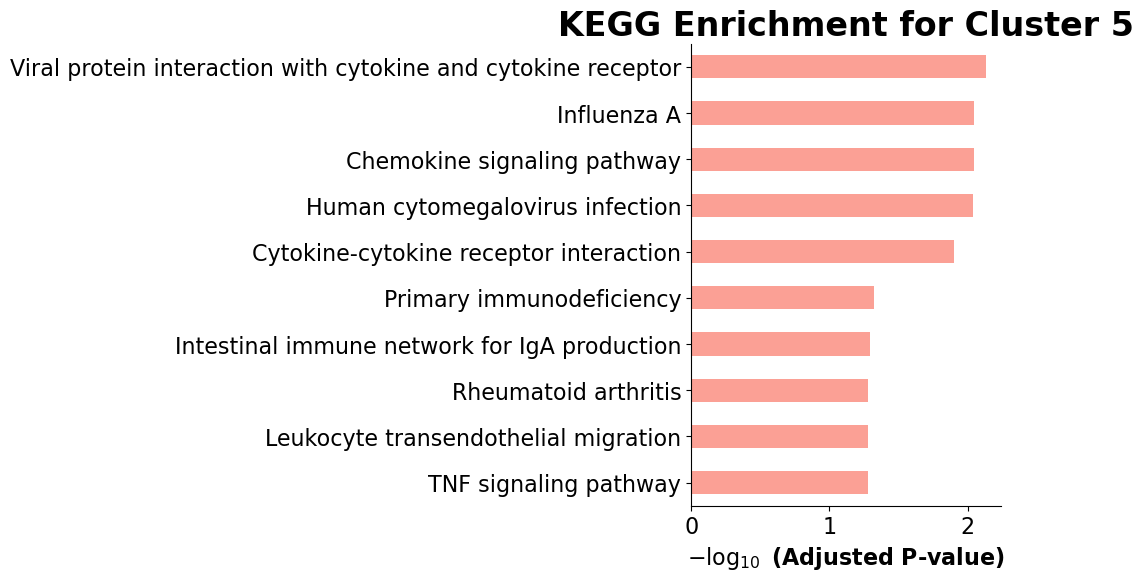

In [60]:
# Plot bar chart of top pathways
gp.barplot(enr.res2d, title='KEGG Enrichment for Cluster 5', cutoff=0.1, top_term=10)


### Discussion

The KEGG pathway enrichment analyses for clusters 0 and 5 provide insights into the biological roles of these cell populations in the tumor microenvironment of pancreatic cancer and its liver metastases. Cluster 5, annotated as Activated T cells (CD69), showed strong enrichment for immune-related pathways, including cytokine-cytokine receptor interaction, chemokine signaling, and the TNF signaling pathway. These results support the role of CD69+ T cells in orchestrating immune responses, inflammation, and potentially immunosuppression within the metastatic site. Given the immunosuppressive nature of the tumor microenvironment described in the original publication, this enrichment highlights how immune cells in metastatic tissues may be engaged in active signaling yet remain functionally impaired or regulated.

Cluster 0, annotated as T cells (CXCR4), was enriched in pathways related to viral infection and cellular stress responses, including necroptosis, endocytosis, and chemokine signaling. This suggests these T cells may be involved in immune surveillance but also possibly exposed to cellular stress or dysregulation within the tumor milieu. Interestingly, the presence of viral infection-related pathways may reflect interferon-driven signatures or mimicry due to tumor signaling mechanisms. The enrichment in axon guidance and cytoskeletal regulation pathways also suggests dynamic migration and positioning, consistent with T cell infiltration patterns.

These two clusters were chosen because they represent key immune cell populations that are central to the immune microenvironment dynamics described in the study. KEGG pathway analysis using GSEApy provided a systematic, statistically robust approach to explore functional enrichment using established gene sets, helping link observed transcriptomic profiles to known biological pathways. While powerful, a limitation is that KEGG enrichment is biased toward well-characterized pathways, potentially missing novel or less-defined biology. Still, these results complement the original findings by showing additional immune signaling activity in specific T cell subtypes within the metastatic niche.